In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from typing import Sequence
from datetime import datetime, timedelta
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, recall_score
from shap import TreeExplainer, summary_plot

# Descriptive statistics
Below is the exploratory analysis of the `flux.csv` file.

- **Size**: The file has 4,180,480 rows and 10 columns.
- **Ranges**:
    - `date`: Categorical variable, there are 14,768 unique dates within the range [1980-01-01, 2020-06-06] that matches the number of days in the intervale.
    - `basin_id`: Categorical varible, there are 503 basins withing the range [1001001, 12930001].
    - `flux`: Continuous variable, it range is [0, 15805] with a mean of 52.53.
    - `precip`: Continuous variable, it range is [0, 213.21] with a mean of 2.95.
    - `temp_max`: Continuous variable measured in celcius degrees, it range is [-11.60, 40.81] with a mean of 13.66.
    - `gauge_name`: Categorical varible, description of `basin_id`, therefore there are 503 unique values.
    - `lat`: Continuous variable, each basin has a unique value, it range is [-54.95, -17.84] with a mean of -36.03. The range matches altmost the complete range of chilean latitudes.
    - `lon`: Continuous variable, each basin has a unique value, it range is [-73.67, -67.64] with a mean of -71.35. The range matches altmost the complete range of chilean longitudes.
    - `mean_elev`: Continuous variable, each basin has a unique value, it range [118.12, 4910.15] with a mean of 1669.90.
    - `area_km2`: Continuous variable, each basin has a unique value, it range [17.89, 52243.67] with a mean of 2417.96.
- **Missing values**
    - 174 basins have missing values in `precip` and `temp_max` in the date range [2020-05-01, 2020-06-06], most of them have null values in some days of that interval, specially in the last few days, probably were are not ready to be collected. The total of missing values per variable are 5433.
    - Also not every basin is present in every date, in average each one is present in 8,311 of 14,768 possible dates.

In [53]:
file_path = "../data/flux.csv"
df = pd.read_csv(file_path, sep=",", parse_dates=["date"])
df.sort_values(["basin_id", "date"], inplace=True)

In [3]:
df.head()

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
0,1980-01-01,1001001,0.579,0.0,10.685653,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
1,1980-01-02,1001001,0.543,0.0,11.470960,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
2,1980-01-03,1001001,0.482,0.0,11.947457,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
3,1980-01-04,1001001,0.459,0.0,12.424489,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
4,1980-01-05,1001001,0.436,0.0,12.649203,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859


In [4]:
df.shape

(4180480, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4180480 entries, 0 to 4180479
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   basin_id    int64         
 2   flux        float64       
 3   precip      float64       
 4   temp_max    float64       
 5   gauge_name  object        
 6   lat         float64       
 7   lon         float64       
 8   mean_elev   float64       
 9   area_km2    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 350.8+ MB


In [6]:
def date_range_is_complete(dates: Sequence[np.datetime64]) -> bool:
    start_date = min(dates)
    end_date = max(dates)
    days = len(dates) - 1
    day_seconds = 24*60*60
    return end_date == start_date + np.timedelta64(day_seconds*days, "s")

In [7]:
date = df.date.unique()
print(f"Number of dates: {len(date)}")
print(f"Range of dates: {str(min(date)), str(max(date))}")
print(f"The range is complete:", date_range_is_complete(date))

Number of dates: 14768
Range of dates: ('1980-01-01T00:00:00.000000000', '2020-06-06T00:00:00.000000000')
The range is complete: True


In [8]:
basin_id = df.basin_id.unique()
print(f"Number of basins: {len(basin_id)}")
print(f"Range of basins: {min(basin_id), max(basin_id)}")

Number of basins: 503
Range of basins: (1001001, 12930001)


In [9]:
gauge_name = df.gauge_name.unique()
print(f"Number of gague names: {len(gauge_name)}")

Number of gague names: 503


In [10]:
df[["flux", "precip", "temp_max"]].describe()

,flux,precip,temp_max
count,4.180480e+06,4.175037e+06,4.175037e+06
mean,5.253340e+01,2.947445e+00,1.365728e+01
std,1.676027e+02,8.766749e+00,6.615037e+00
min,0.000000e+00,0.000000e+00,-1.160359e+01
25%,8.680000e-01,0.000000e+00,9.162867e+00
50%,5.171000e+00,0.000000e+00,1.321396e+01
75%,2.990000e+01,6.422626e-01,1.805745e+01
max,1.580500e+04,2.132120e+02,4.081117e+01


In [11]:
df.groupby("basin_id")[["lat", "lon", "mean_elev", "area_km2"]].first().describe()

,lat,lon,mean_elev,area_km2
count,503.000000,503.000000,503.000000,503.000000
mean,-36.032032,-71.350403,1669.899644,2417.960402
std,8.164583,1.289186,1345.878993,4430.613423
min,-54.946900,-73.666700,118.122945,17.891227
25%,-39.746700,-72.383300,564.257669,321.707240
50%,-36.050000,-71.424700,1146.684138,750.255033
75%,-31.756800,-70.551250,2761.285979,2552.875651
max,-17.842800,-67.639200,4910.151840,52243.667091


In [12]:
df.isna().sum()

date             0
basin_id         0
flux             0
precip        5443
temp_max      5443
gauge_name       0
lat              0
lon              0
mean_elev        0
area_km2         0
dtype: int64

In [13]:
null_predicate = df.precip.isna() | df.temp_max.isna()
dates_with_null = df[null_predicate].date.unique()
null_start_date = min(dates_with_null)
null_end_date = max(dates_with_null)
basin_id_with_null = df[null_predicate].basin_id.unique()

print(f"Number of dates with null values: {len(dates_with_null)}")
print(f"Range of dates with null values: {str(null_start_date), str(null_end_date)}")
print(f"The range is complete:", date_range_is_complete(dates_with_null))
print(f"Number of basins with null values: {len(basin_id_with_null)}")

df[null_predicate].groupby("basin_id").agg({"date": "count"}).describe()

Number of dates with null values: 37
Range of dates with null values: ('2020-05-01T00:00:00.000000000', '2020-06-06T00:00:00.000000000')
The range is complete: True
Number of basins with null values: 174


,date
count,174.000000
mean,31.281609
std,3.662970
min,2.000000
25%,32.000000
50%,32.000000
75%,32.000000
max,37.000000


In [14]:
df[(df.date >= null_start_date) & (df.date <= null_end_date)].groupby("date").agg({"basin_id": "count"})

,basin_id
date,
2020-05-01,4
2020-05-02,4
2020-05-03,4
2020-05-04,4
2020-05-05,4
2020-05-06,171
2020-05-07,172
2020-05-08,172
2020-05-09,172


In [15]:
df.groupby("basin_id").agg({"date": "count"}).describe()

,date
count,503.000000
mean,8311.093439
std,4538.323348
min,175.000000
25%,4348.000000
50%,9003.000000
75%,12560.000000
max,14670.000000


# Time series visualization

Using the widget to add zoom to the signal we can see some patterns.
- There are cyclical patterns that heavily depend of the basin. For instance, the `basin_id=5707002` flux follow a year cycle with peak around January. However, the other examples don't follow the same pattern.
- The precipitation patterns is more similar between examples, following a year cycle with peak around June-July. However, there are some exception as the `basin_id=1050002` (Rio Piga En Collacagua) with peak around December-January.
- The maximum temperature follow the same pattern between examples, following a year cycle with peak around January.

In [4]:
def get_timeserie(
    df: pd.DataFrame,
    cod_station:int,
    variable: str,
    min_date: datetime = datetime(1980, 1, 1),
    max_date: datetime = datetime(2020, 6, 6)
) -> pd.Series:
    predicate = ((df.basin_id == cod_station) &
                 (df.date >= min_date) &
                 (df.date <= max_date))
    timeserie = df[predicate][["date", variable]].sort_values("date")
    return timeserie

def plot_one_timeserie(
    cod_station: int,
    variable: str,
    min_date: datetime = datetime(1980, 1, 1),
    max_date: datetime = datetime(2020, 6, 6)
) -> None:
    timeserie = get_timeserie(df, cod_station, variable, min_date, max_date)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(timeserie.date, timeserie[variable], label=variable)
    
def plot_three_timeseries(
    cod_station: int,
    min_date: datetime = datetime(1980, 1, 1),
    max_date: datetime = datetime(2020, 6, 6),
    variables: list[str] = ["flux", "precip", "temp_max"]
) -> None:
    fig, axs = plt.subplots(1, 3, figsize=(24, 6))
    colors = ["green", "blue", "red"]
    for i, variable in enumerate(variables):
        timeserie = get_timeserie(df, cod_station, variable, min_date, max_date)
        axs[i].plot(timeserie.date, timeserie[variable], label=variable, color=colors[i]) 
        axs[i].set_ylabel(variable)
    axs[1].title.set_text(f"basin_id:{cod_station}")

In [5]:
min_date = datetime(1980, 1, 1)
max_date = datetime(2020, 6, 6)
delta = (max_date - min_date).days

def plot_random_sample_three_timeseries(samples=3, left_delta=0, right_delta=0, variables=["flux", "precip", "temp_max"]):
    np.random.seed(0)
    basin_ids = np.random.choice(df.basin_id.unique(), samples)
    start_date = min_date + timedelta(left_delta)
    end_date = max_date - timedelta(right_delta)
    for basin_id in basin_ids:
        plot_three_timeseries(basin_id, start_date, end_date, variables)
    plt.xlim(start_date, end_date)
    plt.show()

In [58]:
widgets.interact(
    plot_random_sample_three_timeseries,
    samples=(1, 503, 1),
    left_delta=(0, delta, 1),
    right_delta=(0, delta, 1),
    variables=widgets.fixed(["flux", "precip", "temp_max"])
)

interactive(children=(IntSlider(value=3, description='samples', max=503, min=1), IntSlider(value=0, descriptio…

<function __main__.plot_random_sample_three_timeseries(samples=3, left_delta=0, right_delta=0, variables=['flux', 'precip', 'temp_max'])>

# Histogram and boxplot visualization

We can see that the `flux` distribution positiely skewed, that means the median is to the right of the mode and the mean is to the right of the median. The same pattern apply to the `precip`, but more significant. On the other hand, the `temp_max` look more symmetric distribution, usually with two modes.

In [7]:
def plot_three_histbox(
    cod_station: int,
    min_date: datetime = datetime(1980, 1, 1),
    max_date: datetime = datetime(2020, 6, 6)
) -> None:
    variables = ["flux", "precip", "temp_max"]
    colors = ["green", "blue", "red"]
    f, axs = plt.subplots(2, 3, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(24, 6))
    for i, variable in enumerate(variables):
        timeserie = get_timeserie(df, cod_station, variable, min_date, max_date)
        sns.boxplot(data=timeserie, x=variable, ax=axs[0, i], color=colors[i])
        sns.histplot(timeserie[variable], ax=axs[1, i], kde=True, color=colors[i])

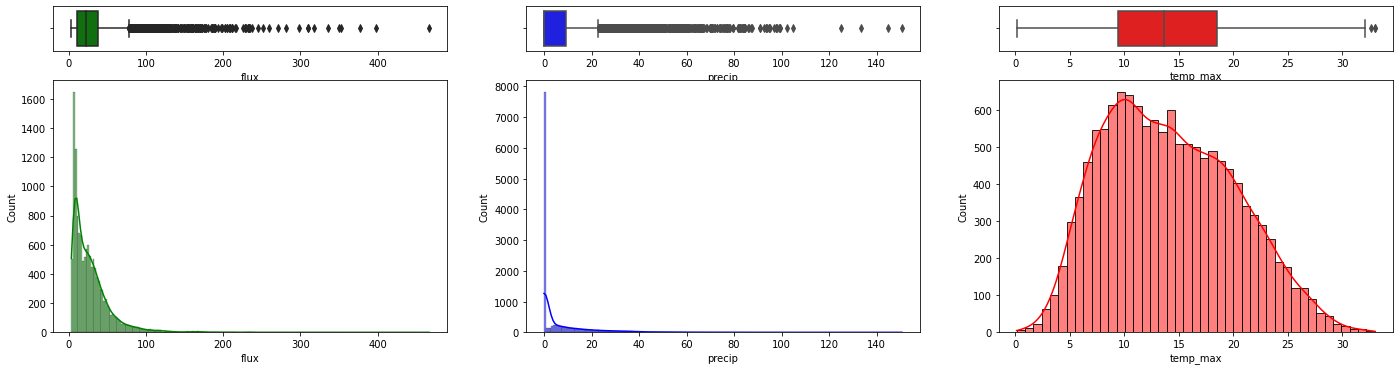

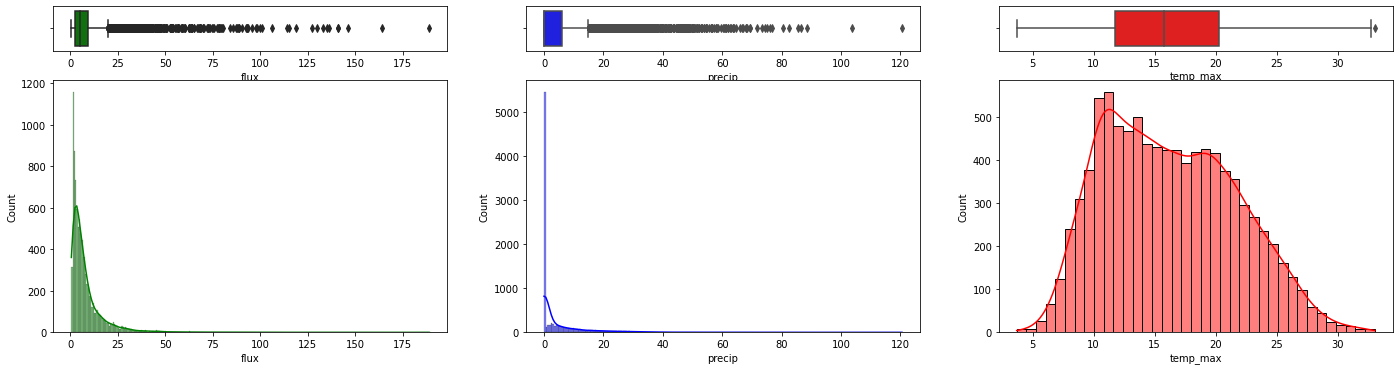

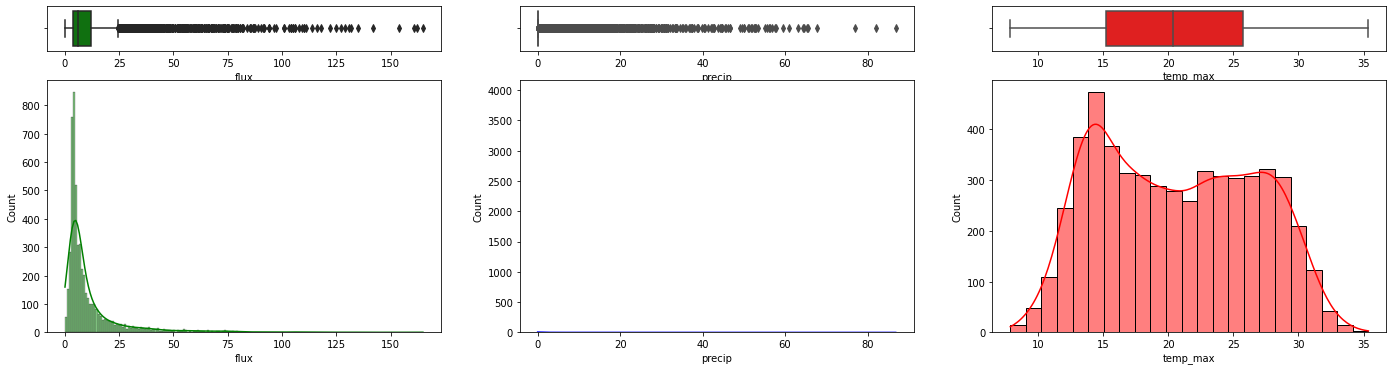

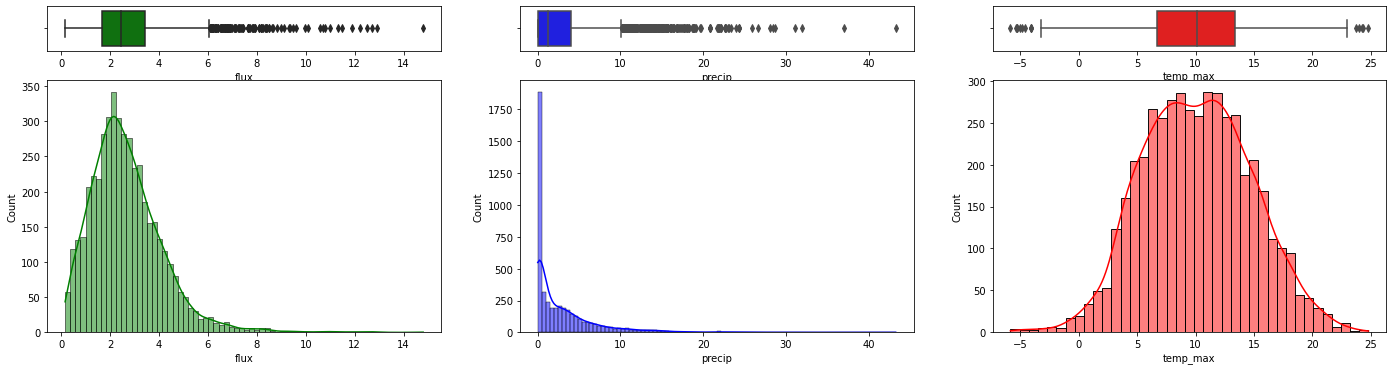

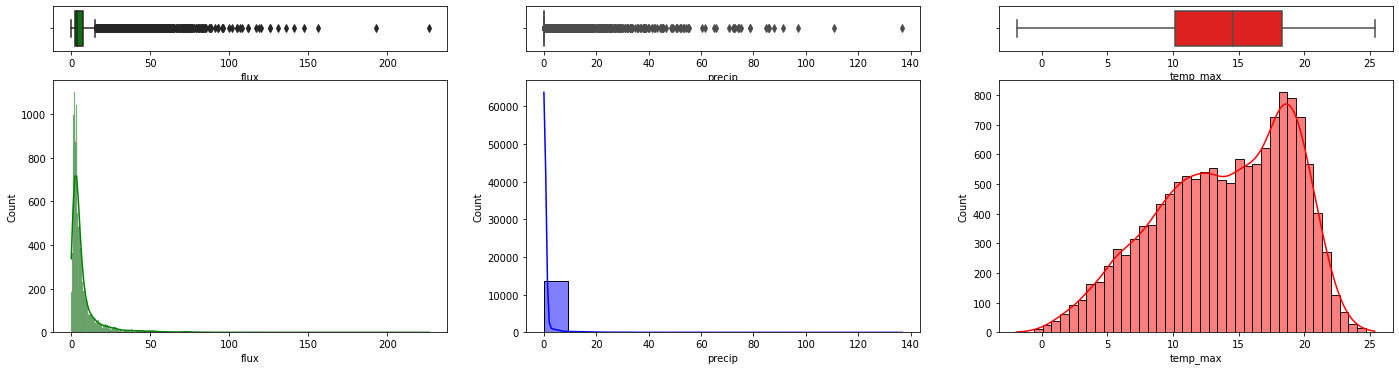

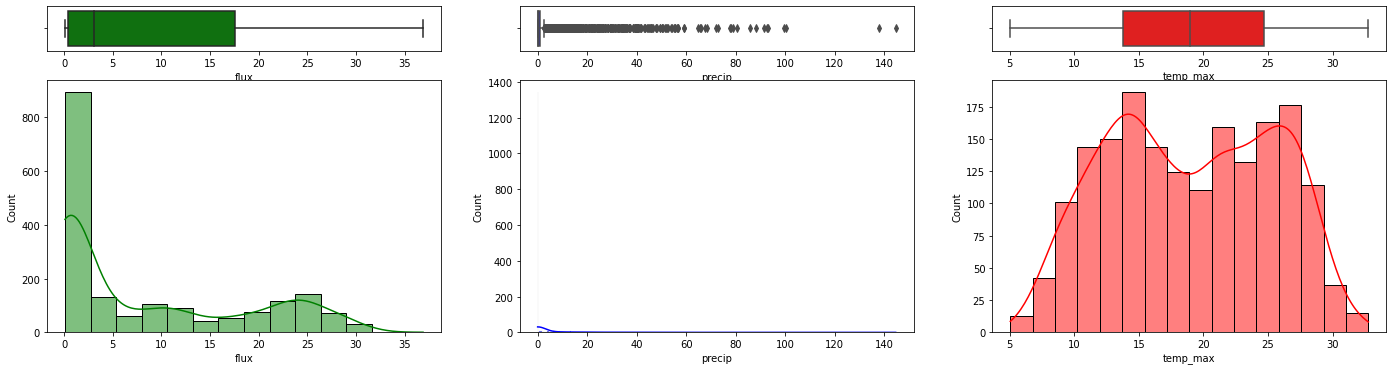

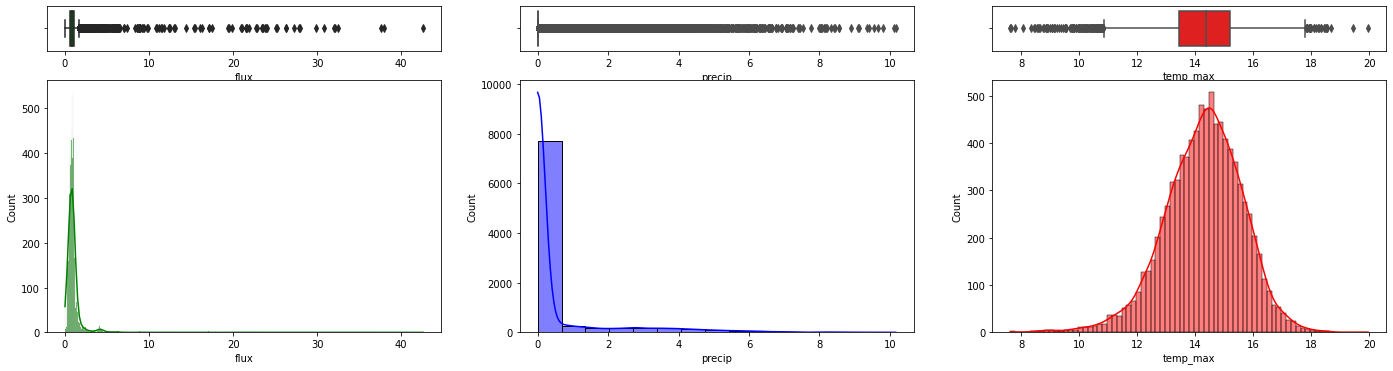

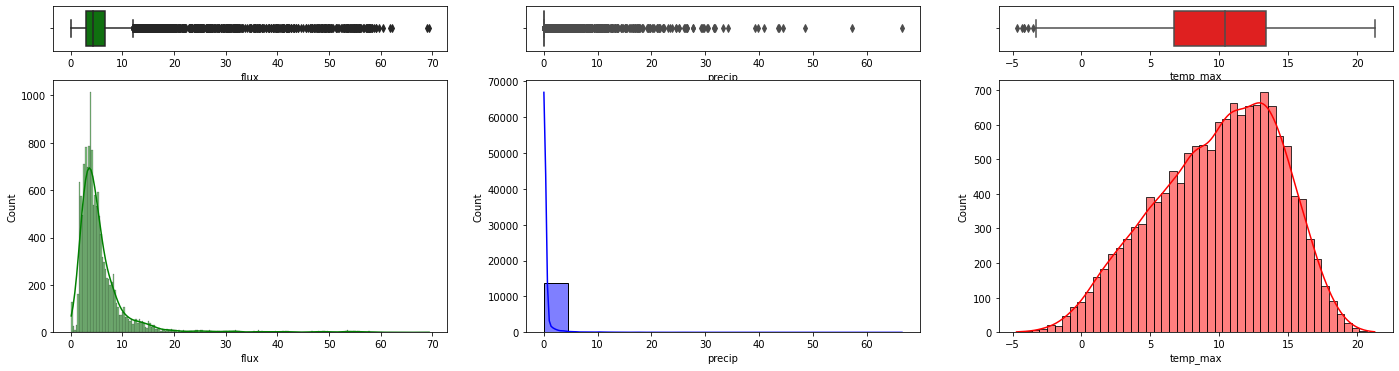

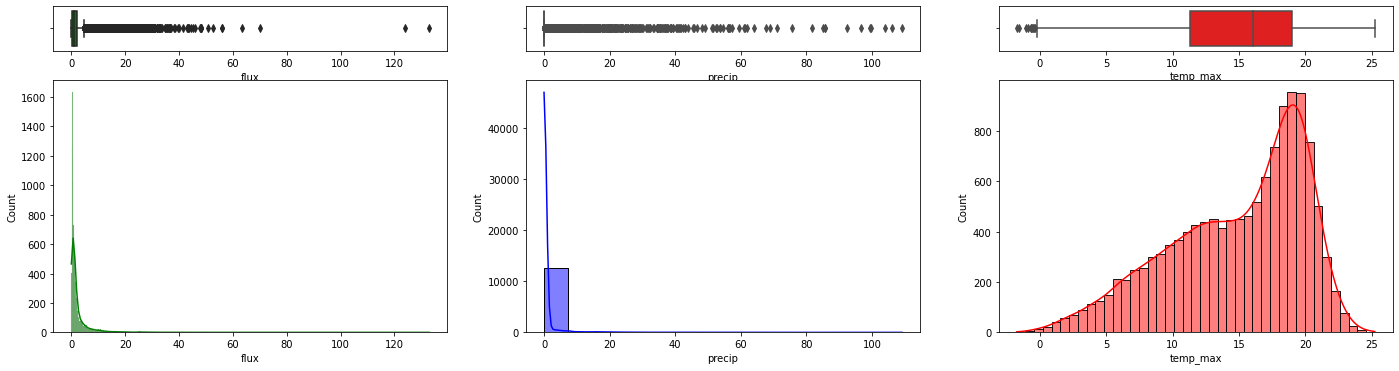

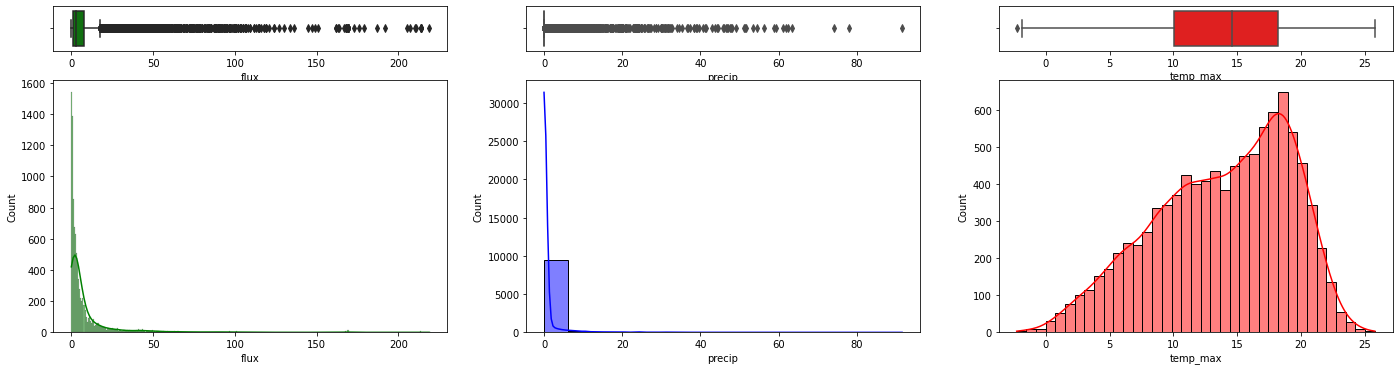

In [20]:
samples = 10
np.random.seed(123)
basin_ids = np.random.choice(df.basin_id.unique(), samples)
for basin_id in basin_ids:
    plot_three_histbox(basin_id)

# Correlation analysis
To interpret the correlation we could use the following table:

|Absolute Interval | Correlation|
|---|---|
|0.00 - 0.199|Very Weak|
|0.20 - 0.399|Weak|
|0.40 - 0.599|Medium|
|0.60 - 0.799|Strong|
|0.80 - 1.000|Very Strong|

Most of varialbes present a very weak or weak correlation. The `flux` present a medium corellation with `area_km`, makes some sense as one would tend to expect a larger area to hold a larger volume of water, obviously that also depends on the depth, inclination and other phenomena). The `lat` and `lon` present a strong correlation, what makes sense given that the Chilean coordinates in general present a high correlation. The `mean_elev` present a very strong correlation with `lat` and `lon`, probably because there is pattern related with Andes Mountains.

<AxesSubplot:>

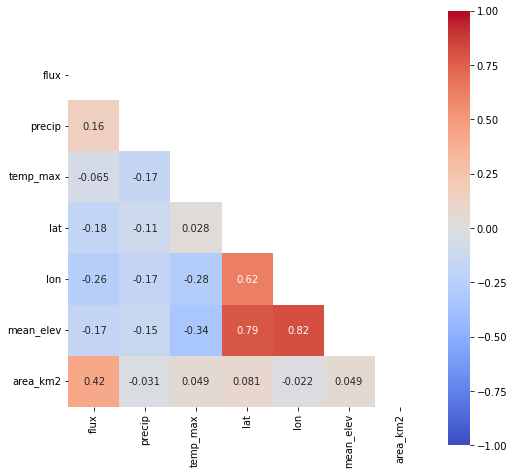

In [21]:
columns = ["flux", "precip", "temp_max", "lat", "lon", "mean_elev", "area_km2"]
corr = df[columns].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr, mask=mask, annot=True, vmin=-1, vmax=1, square=True, cmap="coolwarm")

# Extreme events

The following variables were created:

- `flux_extreme`
- `temp_max_extreme`
- `precip_extreme`

An extreme values is labeles as extreme when is over the 95 percentil of the variable distribution. However, the distribution is very different per season, to have a better definition of an extreme value the distribution was sliced by the month, thus the threshold is defined from the distribution of the variable in that specific month.

A better way of capturing extreme events that was not considered is adding geographic information, for instance, the north of Chile is very different to the south, therefore the definition of extreme value depend of the climate pattern in the particular region. A way to implement this is define polygons, where each point (latitude, longitude) of a polygon shares the climate pattern. Therefore, the threshold would use (latitud, longitude) and season to idenfify an extreme value.

In [55]:
def extreme_dummy(df: pd.DataFrame, variable: str) -> pd.Series:
    thresholds = df.groupby("month")[variable].quantile(0.95)
    mask = 1*(df[variable] > df.month.map(thresholds.to_dict()))
    return mask

df["year"] = pd.DatetimeIndex(df.date).year
df["month"] =  pd.DatetimeIndex(df.date).month
for col in ["flux", "precip", "temp_max"]:
    df[col + "_extreme"] = extreme_dummy(df, col)

## Heterogeneity in `flux_extreme`

A 42% of basins have extreme flux events, 60% have 1 or 0, 70% 10 or les, 90% 821 or less, in other words the `flux_extreme` per basins follow a power law distribution, therefore is very heterogeneous (the distribution of `flux_extreme` per basin are very different).

In [56]:
basin_id_with_flux_extreme = df[df.flux_extreme == 1].basin_id.unique()
percentage_basin_with_flux_extreme = round(100*len(basin_id_with_flux_extreme)/len(df.basin_id.unique()), 2)
print("Percentage of basins with flux extreme events:", percentage_basin_with_flux_extreme)

Percentage of basins with flux extreme events: 41.95


In [24]:
flux_extreme_per_basin = df.groupby("basin_id").agg({"flux_extreme": "sum"})
flux_extreme_per_basin.quantile(np.arange(0, 1, 0.05))

,flux_extreme
0.00,0.0
0.05,0.0
0.10,0.0
0.15,0.0
0.20,0.0
0.25,0.0
0.30,0.0
0.35,0.0
0.40,0.0
0.45,0.0


Text(0.5, 1.0, 'Cumulative distribution of flux_extreme per basin')

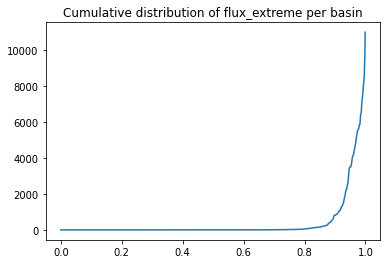

In [25]:
plt.plot(flux_extreme_per_basin.quantile(np.arange(0, 1, 0.001)))
plt.title("Cumulative distribution of flux_extreme per basin")

In [59]:
widgets.interact(
    plot_random_sample_three_timeseries,
    samples=(1, 503, 1),
    left_delta=(0, delta, 1),
    right_delta=(0, delta, 1),
    variables=widgets.fixed(["flux_extreme", "precip_extreme", "temp_max_extreme"])
)

interactive(children=(IntSlider(value=3, description='samples', max=503, min=1), IntSlider(value=0, descriptio…

<function __main__.plot_random_sample_three_timeseries(samples=3, left_delta=0, right_delta=0, variables=['flux', 'precip', 'temp_max'])>

## Frequency of extreme events during time

From a visualization perspective groupby by (year, month) and year is clear that the frequency of `flux_extreme` has increased over time in trend, although there is a cyclical pattern of increase and decrease. However is not clear an increase in`temp_max_extreme` and `precip_extreme`, these look more stationary. 

In [10]:
def plot_monthly_and_yearly_frequency(df: pd.DataFrame, variable: str) -> None:
    df_agg = df.groupby(["year", "month"]).agg({variable: "sum", "date": "count"})
    df_agg[variable] = df_agg[variable]/df_agg["date"]
    df_agg.plot(y=variable)
    df_agg.groupby("year")[variable].describe().plot(y="mean")    

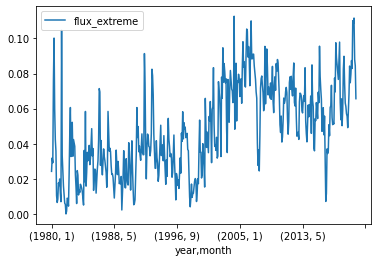

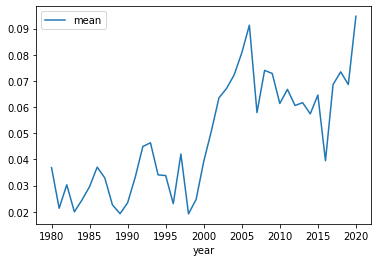

In [11]:
plot_monthly_and_yearly_frequency(df, "flux_extreme")

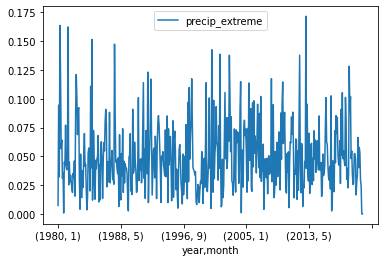

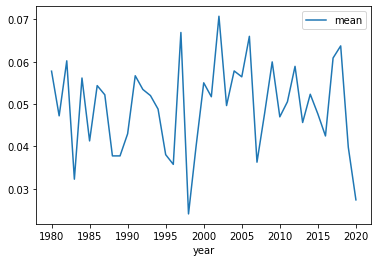

In [12]:
plot_monthly_and_yearly_frequency(df, "precip_extreme")

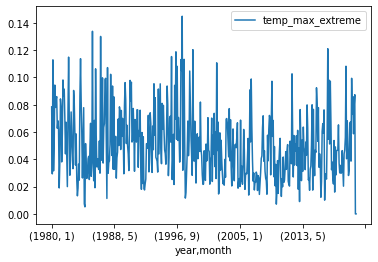

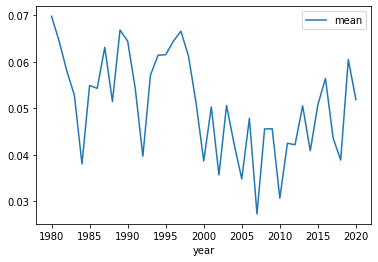

In [13]:
plot_monthly_and_yearly_frequency(df, "temp_max_extreme")

# Extreme flux prediction

There are different way to face this problem. We could build different models to forecast at different levels of anticipation, similar to how weather forecasting works, where we have the forecast for a particular day 1 week ahead, but also a better forcast the previous day or hour. Also we could build a time series model per basin, in that way it encode the historical behaviour to predict the next state. However, the last approach does not use cross-basin information, which is very important because some basins do not have `flux_extreme` events, so a robust solution could be to build a hierarchical time series model.

As a starting point, a non-time series model with some features to encode historical information is preferred. For simplicity, we will focus on predicting the next date with the most up-to-date information.

## Target
As the target is the next date given the current information the dataframe was shifted by -1. It should be noted that the shift operation is applied by basin. Then, the rows with null value in target are removed because there is nothing to predict. 

In [14]:
def get_target(df: pd.DataFrame, periods: int = -1) -> pd.Series:
    basin_ids = df.basin_id.unique()
    target = pd.concat([df[df.basin_id == basin_id].flux_extreme.shift(periods) for basin_id in basin_ids])
    return target

In [15]:
df["target"] = get_target(df)

In [33]:
df.tail(2)

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2,year,month,flux_extreme,precip_extreme,temp_max_extreme,target
4180478,2020-06-05,12930001,0.311,NaN,NaN,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,2020,6,0,0,0,0.0
4180479,2020-06-06,12930001,0.294,NaN,NaN,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,2020,6,0,0,0,NaN


In [26]:
df.isna().sum()

date                   0
basin_id               0
flux                   0
precip              5443
temp_max            5443
gauge_name             0
lat                    0
lon                    0
mean_elev              0
area_km2               0
year                   0
month                  0
flux_extreme           0
precip_extreme         0
temp_max_extreme       0
target               503
dtype: int64

In [16]:
df = df[~df["target"].isna()]
df.isna().sum()

date                   0
basin_id               0
flux                   0
precip              5269
temp_max            5269
gauge_name             0
lat                    0
lon                    0
mean_elev              0
area_km2               0
year                   0
month                  0
flux_extreme           0
precip_extreme         0
temp_max_extreme       0
target                 0
dtype: int64

## Split data

As there is a temporal relationship in the records to be exploited in the feature extraction section, it is not a good idea to randomly split the data as some relevant information from the validation or test sets might get encoded in the training set, which would increase the chances of overfitting, therefore the data will be splitted in ascending order by date.

We are gonna split the data in three sets, training (to adjust model parameter), validation (to adjust hyperparamenter) and testing (to evaluate generalization). As the data is large enough (about 4 million rows), a reasonable split size is 90% for training, 5% for validation and 5% for testing. Note that since the label is not stationary, the imbalance is smaller with time (4.80% in train, 6.08% in validation and 7.27% in test).

In [17]:
acc_per_date = df.groupby("date").agg({"basin_id": "count"})
acc_per_date["acc"] = acc_per_date["basin_id"].cumsum()/len(df)

train_size = 0.9
val_size = 0.05

train_start_date = acc_per_date.index.min()
val_start_date = acc_per_date[acc_per_date.acc > train_size].index.min()
test_start_date = acc_per_date[acc_per_date.acc > train_size + val_size].index.min()

split_map = {(train_start_date, val_start_date): "train",
             (val_start_date, test_start_date): "val",
             (test_start_date, df.date.max() + timedelta(1)): "test"}

df["split"] = ""

for (start_date, end_date), split_name in split_map.items():
    df.loc[(df.date >= start_date) & (df.date < end_date), "split"] = split_name

In [18]:
df_split_agg = df.groupby("split").agg({"date": "count", "flux_extreme": "sum"})
df_split_agg["balance[%]"] = 100*df_split_agg["flux_extreme"]/df_split_agg["date"]
df_split_agg

,date,flux_extreme,balance[%]
split,,,
test,209133,15213,7.274318
train,3761772,180625,4.801594
val,209072,12702,6.075419


## Imputation

The missing data is only presented in the `precip` and `temp_max` variable, both series are almost stationary, so a good imputation method for this case is imputing by the historical mean of the month with missing values. Therefore, a good imputation method for this case is to impute by the historical mean of the month with missing values.

In [19]:
class GroupByMeanImputer(BaseEstimator, TransformerMixin):
    def __init__(self, variable: list[str], by: str) -> None:
        self.variable = variable
        self.by = by

    def fit(self, X: pd.DataFrame, y=None) -> "GroupByMeanImputer":
        self.map = X.groupby(self.by)[self.variable].mean().to_dict()
        self.default_value = X[self.variable].mean()
        return self
        
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_ = X.copy()
        X_[self.variable] = X[self.variable].fillna(value=pd.Series(X.set_index(self.by).index.map(self.map)))
        X_[self.variable] = X_[self.variable].fillna(self.default_value)
        return X_

In [20]:
imputers = [GroupByMeanImputer(variable, "month").fit(df[df.split=="train"]) for variable in ["temp_max", "precip"]]
for imputer in imputers:
    df = imputer.transform(df)

In [21]:
df.describe()

,basin_id,flux,precip,temp_max,lat,lon,mean_elev,area_km2,year,month,flux_extreme,precip_extreme,temp_max_extreme,target
count,4.179977e+06,4.179977e+06,4.179977e+06,4.179977e+06,4.179977e+06,4.179977e+06,4.179977e+06,4.179977e+06,4.179977e+06,4.179977e+06,4.179977e+06,4.179977e+06,4.179977e+06,4.179977e+06
mean,7.179740e+06,5.253300e+01,2.947696e+00,1.365681e+01,-3.569568e+01,-7.129594e+01,1.760140e+03,2.404874e+03,2.001186e+03,6.498757e+00,4.989023e-02,4.993664e-02,4.993353e-02,4.988544e-02
std,3.180962e+06,1.675969e+02,8.761520e+00,6.612372e+00,8.047645e+00,1.254334e+00,1.382125e+03,4.322038e+03,1.126417e+01,3.456971e+00,2.177182e-01,2.178141e-01,2.178077e-01,2.177083e-01
min,1.001001e+06,0.000000e+00,0.000000e+00,-1.160359e+01,-5.494690e+01,-7.366670e+01,1.181229e+02,1.789123e+01,1.980000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.558001e+06,8.680000e-01,0.000000e+00,9.162486e+00,-3.915000e+01,-7.231670e+01,5.847012e+02,3.761001e+02,1.992000e+03,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.350003e+06,5.180000e+00,0.000000e+00,1.321336e+01,-3.588420e+01,-7.137190e+01,1.195311e+03,8.205541e+02,2.002000e+03,7.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,9.416001e+06,2.990000e+01,6.648875e-01,1.805475e+01,-3.126560e+01,-7.050670e+01,3.048161e+03,2.461610e+03,2.011000e+03,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.293000e+07,1.580500e+04,2.132120e+02,4.081117e+01,-1.784280e+01,-6.763920e+01,4.910152e+03,5.224367e+04,2.020000e+03,1.200000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [22]:
df.isna().sum()

date                0
basin_id            0
flux                0
precip              0
temp_max            0
gauge_name          0
lat                 0
lon                 0
mean_elev           0
area_km2            0
year                0
month               0
flux_extreme        0
precip_extreme      0
temp_max_extreme    0
target              0
split               0
dtype: int64

## Features
To encode historical information per basin 2 type of features were created using different window sizes. The first type was the average of [`flux` ,`precip`, `temp_max`] using windows at [7, 30, 90, 360]. Similarly, the second type was the sum of [`flux_extreme`, `precip_extreme`, `temp_max_extreme`] using the same windows. The first 360 values of each serie were removed to have only rows where those features are known.

In [23]:
def groupby_rolling(df: pd.DataFrame, by: str, variable: str, N: int = 7, method="mean") -> pd.Series:
    groups = df[by].unique()
    serie = []
    for group in groups:
        rolling = df[df[by] == group][variable].rolling(N)
        func = getattr(rolling, method)
        serie.append(func())
    return pd.concat(serie)


for col in ["flux", "precip", "temp_max"]:
    for N in [7, 30, 90, 360]:
        df[col + "_mean_last" + str(N)] = groupby_rolling(df, "basin_id", col, N, "mean")
    
for col in ["flux_extreme", "precip_extreme", "temp_max_extreme"]:
    for N in [7, 30, 90, 360]:
        df[col + "_sum_last" + str(N)] = groupby_rolling(df, "basin_id", col, N, "sum")

In [24]:
columns = [col for col in df.columns if "last" in col]
df[columns].describe()

,flux_mean_last7,flux_mean_last30,flux_mean_last90,flux_mean_last360,precip_mean_last7,precip_mean_last30,precip_mean_last90,precip_mean_last360,temp_max_mean_last7,temp_max_mean_last30,...,flux_extreme_sum_last90,flux_extreme_sum_last360,precip_extreme_sum_last7,precip_extreme_sum_last30,precip_extreme_sum_last90,precip_extreme_sum_last360,temp_max_extreme_sum_last7,temp_max_extreme_sum_last30,temp_max_extreme_sum_last90,temp_max_extreme_sum_last360
count,4.176959e+06,4.165390e+06,4.135210e+06,4.000017e+06,4.176959e+06,4.165390e+06,4.135210e+06,4.000017e+06,4.176959e+06,4.165390e+06,...,4.135210e+06,4.000017e+06,4.176959e+06,4.165390e+06,4.135210e+06,4.000017e+06,4.176959e+06,4.165390e+06,4.135210e+06,4.000017e+06
mean,5.253226e+01,5.253380e+01,5.256888e+01,5.247861e+01,2.947894e+00,2.949027e+00,2.950768e+00,2.945029e+00,1.365560e+01,1.365059e+01,...,4.484858e+00,1.781274e+01,3.496204e-01,1.499663e+00,4.500348e+00,1.796044e+01,3.495284e-01,1.497753e+00,4.488364e+00,1.781515e+01
std,1.601343e+02,1.512774e+02,1.437127e+02,1.286003e+02,5.561423e+00,4.057708e+00,3.418699e+00,2.451433e+00,6.264456e+00,6.014514e+00,...,1.697817e+01,6.299022e+01,8.105283e-01,2.292864e+00,5.604672e+00,1.825445e+01,1.062469e+00,3.691511e+00,1.014252e+01,3.524613e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-03,0.000000e+00,0.000000e+00,0.000000e+00,1.462239e-03,-7.976830e+00,-5.095718e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.978571e-01,9.620667e-01,1.085614e+00,1.509669e+00,3.045183e-15,2.328644e-01,4.315611e-01,7.900803e-01,9.372544e+00,9.506610e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.385714e+00,5.851333e+00,6.709511e+00,9.302647e+00,5.692650e-01,1.321185e+00,1.633650e+00,2.265131e+00,1.321675e+01,1.319466e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
75%,3.077143e+01,3.234215e+01,3.422111e+01,3.746988e+01,3.318638e+00,3.971217e+00,4.253707e+00,4.749779e+00,1.783210e+01,1.766720e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,7.000000e+00,2.900000e+01,0.000000e+00,1.000000e+00,4.000000e+00,1.700000e+01
max,7.516000e+03,4.599533e+03,3.374689e+03,1.523203e+03,1.000123e+02,3.966291e+01,2.547476e+01,1.318740e+01,3.573834e+01,3.283245e+01,...,9.000000e+01,3.600000e+02,7.000000e+00,2.500000e+01,5.600000e+01,1.360000e+02,7.000000e+00,3.000000e+01,8.800000e+01,2.740000e+02


In [25]:
df[columns].isna().sum()

flux_mean_last7                   3018
flux_mean_last30                 14587
flux_mean_last90                 44767
flux_mean_last360               179960
precip_mean_last7                 3018
precip_mean_last30               14587
precip_mean_last90               44767
precip_mean_last360             179960
temp_max_mean_last7               3018
temp_max_mean_last30             14587
temp_max_mean_last90             44767
temp_max_mean_last360           179960
flux_extreme_sum_last7            3018
flux_extreme_sum_last30          14587
flux_extreme_sum_last90          44767
flux_extreme_sum_last360        179960
precip_extreme_sum_last7          3018
precip_extreme_sum_last30        14587
precip_extreme_sum_last90        44767
precip_extreme_sum_last360      179960
temp_max_extreme_sum_last7        3018
temp_max_extreme_sum_last30      14587
temp_max_extreme_sum_last90      44767
temp_max_extreme_sum_last360    179960
dtype: int64

In [26]:
df.dropna(inplace=True)
df.isna().sum()

date                            0
basin_id                        0
flux                            0
precip                          0
temp_max                        0
gauge_name                      0
lat                             0
lon                             0
mean_elev                       0
area_km2                        0
year                            0
month                           0
flux_extreme                    0
precip_extreme                  0
temp_max_extreme                0
target                          0
split                           0
flux_mean_last7                 0
flux_mean_last30                0
flux_mean_last90                0
flux_mean_last360               0
precip_mean_last7               0
precip_mean_last30              0
precip_mean_last90              0
precip_mean_last360             0
temp_max_mean_last7             0
temp_max_mean_last30            0
temp_max_mean_last90            0
temp_max_mean_last360           0
flux_extreme_s

## Metrics

Since the problem is well unbalanced, a model that classifies everything as a non-extreme events could have over 90% of accuracy, which is not very useful. We need a metric that capture the importance of the minority class. The macro-recall aggregate the recall of each class, therefore the number of samples of each class is not relevant and model with better performance would be the one that on average has the best percentage correct per class. An even better way would be a profit function, with benefits/costs assigned to matches/errors. However, those cost are hard to estimate.

In [27]:
def get_best_model(clfs, X, y):
    best_score = 0.0
    best_clf = clfs[0]
    for clf in clfs:
        y_pred = clf.predict(X)
        score = recall_score(y, y_pred, average="macro")
        if score > best_score:
            best_clf = clf
            best_score = score
    return best_clf

In [28]:
def plot_confusion_matrix(cm: np.array, classes: list[str], normalize: bool = True, title: str = 'Confusion matrix') -> None:
    """    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8,8))
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, decimals=3)

        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    plt.colorbar()

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Training
Since the target (label) is binary we have a classification problem. Logistic regression is good baseline to have point of comparison with more complex classifier as Bagging or Boosting.

In [29]:
features = [
    "lat", "lon", "mean_elev", "area_km2",
    "flux", "precip", "temp_max",
    "flux_extreme", "precip_extreme", "temp_max_extreme",
    "flux_mean_last7", "flux_mean_last30", "flux_mean_last90", "flux_mean_last360",
    "precip_mean_last7", "precip_mean_last30", "precip_mean_last90", "precip_mean_last360",
    "temp_max_mean_last7", "temp_max_mean_last30", "temp_max_mean_last90", "temp_max_mean_last360",
    "flux_extreme_sum_last7", "flux_extreme_sum_last30", "flux_extreme_sum_last90", "flux_extreme_sum_last360",
    "precip_extreme_sum_last7", "precip_extreme_sum_last30", "precip_extreme_sum_last90", "precip_extreme_sum_last360",
    "temp_max_extreme_sum_last7", "temp_max_extreme_sum_last30", "temp_max_extreme_sum_last90", "temp_max_extreme_sum_last360"]
target = "target"

In [30]:
X_train, y_train = df[df.split == "train"][features], df[df.split == "train"]["target"]
X_val, y_val = df[df.split == "val"][features], df[df.split == "val"]["target"]
X_test, y_test = df[df.split == "test"][features], df[df.split == "test"]["target"]

### Logistic Regression

In [50]:
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(max_iter=1000)

Normalized confusion matrix


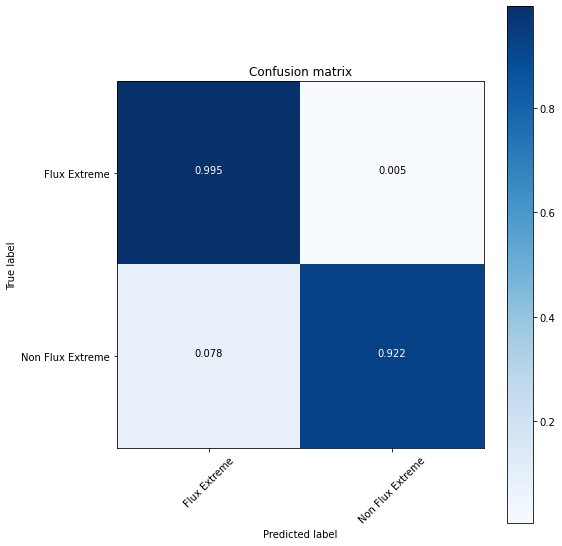

Macro Recall: 95.8647[%]


In [51]:
y_test_pred = lr_clf.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, ["Flux Extreme", "Non Flux Extreme"])
score = recall_score(y_test, y_test_pred, average="macro")
print(f"Macro Recall: {100*score:.4f}[%]")

### Random Forest

In [31]:
params = {"n_estimators": range(10, 40, 10), "max_depth": range(2, 4, 1)}
clfs = []
for n_estimators, max_depth in itertools.product(*params.values()):
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0, n_jobs=-1)
    clf.fit(X_train, y_train)
    clfs.append(clf)

In [32]:
rf_clf = get_best_model(clfs, X_val, y_val)

Normalized confusion matrix


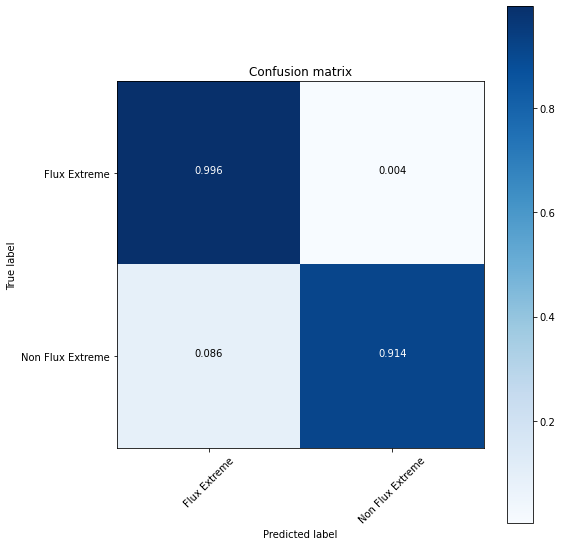

Macro Recall: 95.4731[%]


In [33]:
y_test_pred = rf_clf.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, ["Flux Extreme", "Non Flux Extreme"])
score = recall_score(y_test, y_test_pred, average="macro")
print(f"Macro Recall: {100*score:.4f}[%]")

### XGBoost

In [34]:
params = {"n_estimators": range(10, 40, 10), "max_depth": range(2, 4, 1)}
clfs = []
for n_estimators, max_depth in itertools.product(*params.values()):
    clf = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0, n_jobs=-1)
    clf.fit(X_train, y_train)
    clfs.append(clf)

In [35]:
xgb_clf = get_best_model(clfs, X_val, y_val)

Normalized confusion matrix


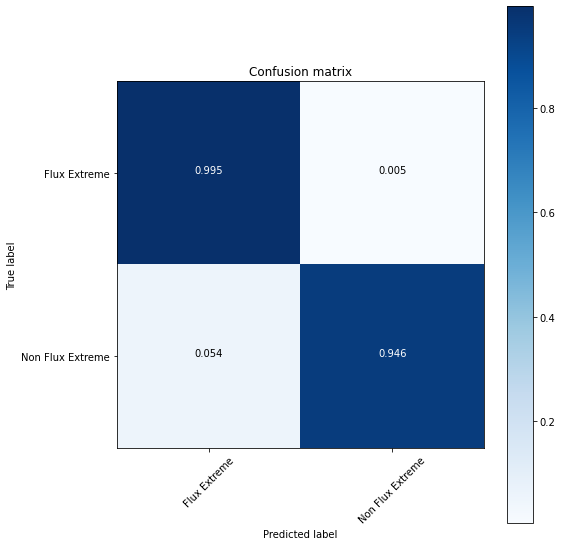

Macro Recall: 97.0504[%]


In [36]:
y_test_pred = xgb_clf.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, ["Flux Extreme", "Non Flux Extreme"])
score = recall_score(y_test, y_test_pred, average="macro")
print(f"Macro Recall: {100*score:.4f}[%]")

## Conclusions of the model analysis

The best model is the XGBoost, because it performs better (highest macro-recall) on the test set, having a macro-recall of 97.05%,  According to the results generalizing very well on unseen data. 

The feature importance was computed with SHAP Values. It is model agnostic and using the Shapley value from game theory to estimate the how does each feature contribute to the prediction. From the graphic we can see that the most relevant variables are [`flux`, `precip`, `flux_extreme`, `flux_extreme_sum_last360`, `flux_extreme_sum_last30`, `flux_extreme_sum_last7`]. It shows that recent extreme events have a signifficant impact in classifing correctly whether the next event will be extreme or not, specially the level of `flux` in the previous date.

How was mencioned before a hierarchical time series could use better the historical data to predict the future. As the problem is well unbalanced some sampling technique as SMOTE (Synthetic Oversampling Technique) could improve the performance. Since according to the feature importance graph there are some variables that provide little information whose elimination can have performance improvements. Also, some feature transformation could improve the model perfomance, for instance Z-score or Min-Max in the case of the Logistic Regression. Finally, probably the actual challenge would be predict the extreme events with more days in advance, for instance 1 week, because 1 day could be not enough to execute a emergency plan.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


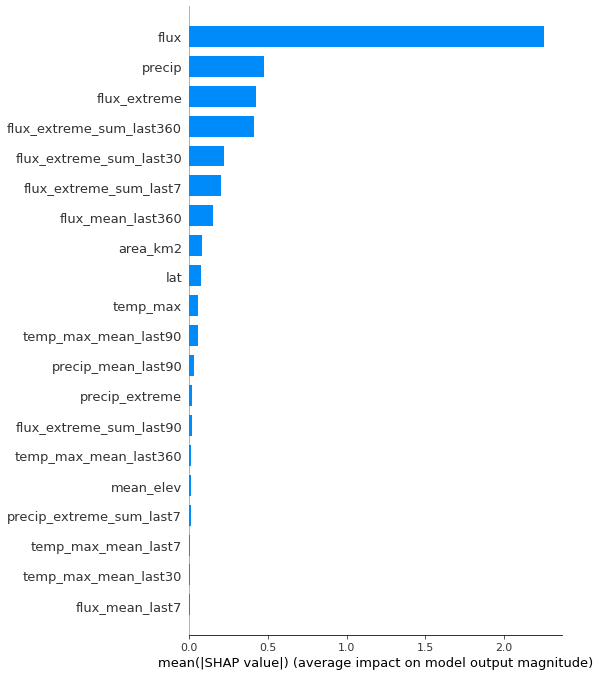

In [37]:
explainer = TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_train, approximate=True)
summary_plot(shap_values, X_train, plot_type="bar")